In [17]:
from typing import Sequence, Annotated, TypedDict
from dotenv import load_dotenv
#the foundational class for all messag type sin langgraph
from langchain_core.messages import BaseMessage 
from langchain_core.messages import ToolMessage
#Message for providing instructions to the LLM 
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

load_dotenv("./.env")



True

In [33]:
"""
`Annotated` es una herramienta del módulo `typing` de 
Python que te permite añadir metadatos o información extra 
a las pistas de tipo (type hints).

Piensa en ello como una forma de poner una "nota" en una variable 
para que otras herramientas o librerías sepan cómo tratarla de 
una manera especial.

En tu código:

```python
messages: Annotated[Sequence[BaseMessage], add_messages]
```

1.  **`Sequence[BaseMessage]`**: Esta es la pista de tipo normal. 
Le dice a Python que `messages` debe ser una secuencia (como una lista) 
de objetos `BaseMessage`.
2.  **`add_messages`**: Esta es la "nota" o la anotación. 
Es una función especial de LangGraph. 
Al añadirla aquí, le estás diciendo a tu grafo: 
"Cuando un nodo devuelva un valor para `messages`, 
no reemplaces el valor antiguo. 
En su lugar, **añade** los nuevos mensajes a la lista existente".

En resumen, `Annotated` se usa aquí para instruir a LangGraph 
a que **acumule** los mensajes en el estado en lugar 
de sobrescribirlos en cada paso, lo cual es fundamental 
para que el agente recuerde el historial de la conversación.


"""

class AgentState(TypedDict):
    #historial de messages de forma acumulativa
    #Anottated Añadir metadatos o informacion extra a las pistas
    # de tipo
    #Sequence: type de 
    messages: Annotated[Sequence[BaseMessage], add_messages]



@tool
def add(a: int , b:int):
    """ This is an addition function that adds 2 numbers together"""
    return a+b

@tool
def multiply(a: int , b:int):
    """ this is an multiply function that multiply 2 numbers together"""
    return a*b

tools = [add, multiply]
model = ChatOpenAI(model= "gpt-4o")


def model_call(state: AgentState) -> AgentState:
    """ Eres un agente que obtiene la informacion"""
    system_prompt = SystemMessage(
        "You are my AI assistant, please answer my query to the best  of your ability"
    )
    print(f"\n model_call ->  state[messages] : {state['messages']}")
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}


def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    print(f"\n should_continue -> last_message : {last_message}")
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"
    


In [34]:
tool_node = ToolNode(tools=tools)
graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)
graph.add_node("tools", tool_node)
graph.add_edge(START,"our_agent")
graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
     "continue": "tools",
     "end": END,
    }
)
graph.add_edge("tools","our_agent")

app = graph.compile()


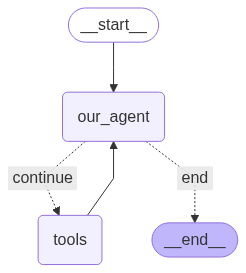

In [35]:

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage

def print_stream(stream):
    """
    Imprime el stream de ejecución del grafo de LangGraph de forma clara.
    Muestra el nodo que se ejecuta, las llamadas a herramientas, los resultados
    y la respuesta final del agente.
    """
    for s in stream:
        # El stream devuelve un diccionario donde la clave es el nombre del nodo
        # y el valor es el estado actualizado.
        node_name = list(s.keys())[0]
        state_update = s[node_name]
        
        # Obtenemos el último mensaje añadido al estado
        last_message = state_update["messages"][-1]

        print(f"--- Nodo Ejecutado: '{node_name}' ---")

        # Usamos pretty_print() que ya formatea bien los mensajes de LangChain
        last_message.pretty_print()
        
        print("--------------------------------------\n")


# Probamos con una pregunta que requiere la herramienta de multiplicar
inputs = {"messages" : [("user", "cuanto es 3 multiplicado por 4?")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 3  *  4

 model_call ->  state[messages] : [HumanMessage(content='Add 3  *  4', additional_kwargs={}, response_metadata={}, id='1ecd9fa9-65d3-4a35-8493-c0cf4a34e163')]

 should_continue -> last_message : content='The expression \\( 3 \\times 4 \\) equals 12. If you meant to add the result of this multiplication to something else, please provide the additional details.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 36, 'total_tokens': 71, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'finish_reason': 'stop', 'logprobs': None} id='run-158ae0d3-a655-4cdd-ad01-6f9404237727-0' usage_metadata={'input_tokens': 36